In [2]:
import xarray as xr
import numpy as np
import ssebop
import matplotlib.pyplot as plt
from os import listdir,mkdir
from os.path import isfile, join, isdir
import requests

def is_leap_year(year):
    """ if year is a leap year return True
        else return False """
    if year % 100 == 0:
        return year % 400 == 0
    return year % 4 == 0

def doy(Y,M,D):
    """ given year, month, day return day of year
        Astronomical Algorithms, Jean Meeus, 2d ed, 1998, chap 7 """
    if is_leap_year(Y):
        K = 1
    else:
        K = 2
    N = int((275 * M) / 9.0) - K * int((M + 9) / 12.0) + D - 30
    return N

def ymd(Y,N):
    """ given year = Y and day of year = N, return year, month, day
        Astronomical Algorithms, Jean Meeus, 2d ed, 1998, chap 7 """    
    if is_leap_year(Y):
        K = 1
    else:
        K = 2
    M = int((9 * (K + N)) / 275.0 + 0.98)
    if N < 32:
        M = 1
    D = N - int((275 * M) / 9.0) + K * int((M + 9) / 12.0) + 30
    return Y, M, D

In [2]:
def get_nc_files(year):
    mkdir("./data/gridmet/"+year)
    
    url = 'https://www.northwestknowledge.net/metdata/data/tmmn_'+year+'.nc'
    r = requests.get(url)
    with open('./data/gridmet/'+year+'/tmin.nc', 'wb') as f:
        f.write(r.content)
    
    url = 'https://www.northwestknowledge.net/metdata/data/tmmx_'+year+'.nc'
    r = requests.get(url)
    with open('./data/gridmet/'+year+'/tmax.nc', 'wb') as f:
        f.write(r.content)
    
    url = 'https://www.northwestknowledge.net/metdata/data/etr_'+year+'.nc'
    r = requests.get(url)
    with open('./data/gridmet/'+year+'/etr.nc', 'wb') as f:
        f.write(r.content)

In [3]:
landsat_path = "./data/landsat/"
gridmet_path = "./data/gridmet/"
output_path = "./data/calculated_et/"

onlyfiles = [f for f in listdir(landsat_path) if isfile(join(landsat_path, f))]

elev_rdd = xr.open_dataset("./data/gridmet/" + "elev.nc").sel(day=1)

for file in onlyfiles:
    print(file)
    
    name_split = file.split("_")
    year = name_split[2]
    month = name_split[3]
    day = name_split[4]
#     day_of_year = doy(int(year), int(month), int(day))
    date = year+"-"+month+"-"+day
    
    if isdir(gridmet_path+year) == False:
        get_nc_files(year)
        
    tmin_rdd = xr.open_dataset("./data/gridmet/"+year+"/tmin.nc").sel(day=date)
    tmax_rdd = xr.open_dataset("./data/gridmet/"+year+"/tmax.nc").sel(day=date)
    etr_rdd = xr.open_dataset("./data/gridmet/"+year+"/etr.nc").sel(day=date)
    
    tmin_rdd["tmin"] = tmin_rdd["air_temperature"]
    tmin_rdd = tmin_rdd.drop(["air_temperature"])
    tmin_rdd = tmin_rdd.drop_dims("crs")
    
    tmax_rdd["tmax"] = tmax_rdd["air_temperature"]
    tmax_rdd = tmax_rdd.drop(["air_temperature"])
    tmax_rdd = tmax_rdd.drop_dims("crs")
    
    etr_rdd["etr"] = etr_rdd["potential_evapotranspiration"]
    etr_rdd = etr_rdd.drop(["potential_evapotranspiration"])
    etr_rdd = etr_rdd.drop_dims("crs")
    
    landsat_data = np.load('./data/landsat/'+file)
    
    band3 = xr.DataArray(
        data=landsat_data[0, 2],
        dims=["y", "x"],
        coords=dict(
            lon=(["y", "x"], landsat_data[0,12]),
            lat=(["y", "x"], landsat_data[0,11]),
        ),
    )
    band4 = xr.DataArray(
        data=landsat_data[0, 3],
        dims=["y", "x"],
        coords=dict(
            lon=(["y", "x"], landsat_data[0,12]),
            lat=(["y", "x"], landsat_data[0,11]),
        ),
    )
    band8 = xr.DataArray(
        data=landsat_data[0, 7],
        dims=["y", "x"],
        coords=dict(
            lon=(["y", "x"], landsat_data[0,12]),
            lat=(["y", "x"], landsat_data[0,11]),
        ),
    )
    
    ssebop_img = ssebop.Ssebop(
        band3,
        band4,
        band8,
        etr_rdd,
        tmax_rdd,
        tmin_rdd,
        elev_rdd,
        et_reference_factor=None,
        et_reference_resample="linear",
        tmax_resample="linear",
        elev_resample="linear",
    )
    
#     plt.clf()
#     band3.plot()

#     plt.clf()
#     ssebop_img.interpolated_dt.plot()
    
#     plt.clf()
#     ssebop_img.lst.plot()
    
#     plt.clf()
#     ssebop_img.tcorr.plot()
    
#     plt.clf()
#     ssebop_img.et_reference.plot()
    
#     plt.clf()
#     ssebop_img.et_fraction.plot()
    
#     plt.clf()
#     ssebop_img.et.plot()

    output_filename = name_split[0]+"_"+name_split[1]+"_"+name_split[2]+"_"+name_split[3]+"_"+name_split[4]+".nc"
    output_filename = output_path+output_filename
    
    eta = ssebop_img.et
    eta.to_netcdf(path=output_filename)
    
    print ('finished saving')

AKR02_9xnsm_2020_01_16_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_01_25_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_02_01_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_02_10_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_02_17_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_02_26_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_03_04_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_03_20_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_03_29_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_04_05_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_04_14_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_04_21_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_04_30_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_05_07_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_05_16_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_05_23_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_06_01_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_06_08_0.53.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_06_17_0.57.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_06_24_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_07_03_0.46.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_07_10_0.51.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_07_19_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_07_26_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_08_04_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_08_11_0.47.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_08_20_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_08_27_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_09_05_0.45.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_09_12_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_09_21_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_09_28_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_10_07_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_10_14_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_10_23_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_10_30_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_11_15_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_11_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_12_01_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AKR02_9xnsm_2020_12_17_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_01_07_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_01_16_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_01_23_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_02_01_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_02_17_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_02_24_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_03_04_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_03_11_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_03_20_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_03_27_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_04_05_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_04_12_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_04_21_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_04_28_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_05_07_0.45.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_05_23_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_05_30_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_06_08_0.44.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_06_15_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_06_24_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_07_01_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_07_10_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_07_17_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_07_26_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_08_02_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_08_11_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_08_18_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_08_27_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_09_03_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_09_12_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_09_19_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_09_28_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_10_05_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_10_14_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_10_21_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_10_30_-999.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_11_15_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_11_22_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_12_01_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_12_08_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_12_17_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ALT01_9xjwc_2020_12_24_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_01_16_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_01_25_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_02_01_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_02_10_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_02_17_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_02_26_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_03_04_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_03_13_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_03_20_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_03_29_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_04_05_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_04_14_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_04_21_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_04_30_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'ai

finished saving
AVN01_9wvc6_2020_05_07_0.32.npy
finished saving
AVN01_9wvc6_2020_05_16_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_05_23_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_06_01_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_06_08_0.44.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_06_17_0.44.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_06_24_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_07_03_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_07_10_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_07_19_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_07_26_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_08_04_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_08_11_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_08_20_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_08_27_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_09_05_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_09_12_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_09_21_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_09_28_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_10_07_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_10_14_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_10_23_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_10_30_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_11_08_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_11_15_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_11_24_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_12_01_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
AVN01_9wvc6_2020_12_17_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_01_07_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_01_23_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_02_08_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_02_24_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_03_11_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_03_27_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_04_12_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_04_28_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_05_14_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_05_30_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_06_15_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_07_01_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_07_17_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_08_02_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_08_18_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_09_03_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_09_19_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_10_05_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_10_21_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_11_22_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_12_08_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BNV01_9wusc_2020_12_24_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_01_16_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_02_01_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_02_17_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_03_04_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_03_20_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_04_05_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_04_21_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_05_07_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_05_23_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_06_08_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_06_24_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_07_10_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_07_26_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_08_11_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_08_27_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_09_12_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_09_28_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_10_14_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_10_30_-999.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_11_15_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_12_01_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRG01_9xjyf_2020_12_17_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_01_05_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_01_14_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_01_21_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_01_30_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_02_06_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_02_22_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_03_02_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_03_25_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_04_03_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_04_10_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_04_19_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_04_26_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_05_05_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_05_12_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_05_21_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_05_28_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_06_06_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_06_13_0.45.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_06_22_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_06_29_0.44.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_07_08_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_07_15_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_07_31_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_08_09_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_08_16_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_08_25_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_09_01_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_09_10_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_09_17_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_09_26_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_10_03_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_10_12_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_10_19_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_10_28_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_11_13_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_11_20_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_11_29_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_12_06_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_12_15_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRK01_9wfd1_2020_12_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_01_02_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_01_18_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_01_25_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_02_03_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_02_10_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_02_19_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_02_26_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_03_06_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_03_22_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_03_29_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_04_07_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_04_14_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_04_23_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_04_30_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_05_09_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_05_16_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_05_25_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_06_01_0.49.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_06_10_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_06_17_0.64.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_06_26_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_07_03_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_07_12_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_07_19_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_07_28_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_08_04_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_08_13_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_08_20_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_08_29_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_09_05_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_09_14_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_09_21_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_09_30_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_10_07_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_10_16_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_10_23_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_11_08_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_11_17_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_11_24_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_12_03_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL02_9wzrk_2020_12_19_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_01_02_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_01_18_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_01_25_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_02_03_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_02_10_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_02_19_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_02_26_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_03_06_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_03_22_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_03_29_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_04_07_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_04_14_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_04_23_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_04_30_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_05_09_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_05_16_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_05_25_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_06_01_0.48.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_06_10_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_06_17_0.6.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_06_26_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_07_03_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_07_12_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_07_19_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_07_28_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_08_04_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_08_13_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_08_20_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_08_29_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_09_05_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_09_14_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_09_21_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_09_30_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_10_07_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_10_16_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_10_23_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'ai

finished saving
BRL03_9wzrf_2020_11_08_0.23.npy
finished saving
BRL03_9wzrf_2020_11_17_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_11_24_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_12_03_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
BRL03_9wzrf_2020_12_19_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_01_07_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_01_14_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_01_23_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_02_08_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_02_24_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_03_02_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_03_11_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_03_27_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_04_03_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_04_12_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_04_19_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_04_28_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_05_05_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_05_14_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_05_21_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_05_30_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_06_06_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_06_15_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_06_22_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_07_01_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_07_08_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_07_17_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_07_24_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_08_02_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_08_09_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_08_18_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_08_25_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_09_03_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_09_10_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_09_19_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_09_26_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_10_05_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_10_12_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_10_21_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_10_28_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_11_13_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_11_22_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_11_29_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_12_08_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_12_15_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBL01_9wgzb_2020_12_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_01_05_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_01_14_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_01_21_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_02_06_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_02_22_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_03_02_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_03_25_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_04_03_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_04_10_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_04_19_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_04_26_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_05_05_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_05_12_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_05_21_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_05_28_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_06_06_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_06_13_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_06_22_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_06_29_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_07_08_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_07_15_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_07_24_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_07_31_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_08_09_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_08_16_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_08_25_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_09_01_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_09_10_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_09_17_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_09_26_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_10_03_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_10_12_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_10_19_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_10_28_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_11_13_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_11_20_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_11_29_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_12_06_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_12_15_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CBN01_9wgpn_2020_12_22_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_01_07_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_01_16_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_01_23_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_02_01_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_02_17_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_02_24_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_03_04_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_03_11_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_03_20_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_03_27_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_04_05_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_04_12_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_04_21_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_04_28_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_05_07_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_05_23_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_05_30_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_06_08_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_06_15_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_06_24_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_07_01_0.45.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_07_10_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_07_17_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_07_26_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_08_02_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_08_11_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_08_18_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_08_27_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_09_03_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_09_12_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_09_19_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_09_28_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_10_05_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_10_14_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_10_21_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_10_30_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_11_15_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_11_22_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_12_01_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_12_08_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_12_17_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CCR01_9xj3r_2020_12_24_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_01_07_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_01_16_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_01_23_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_02_01_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_02_08_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_02_17_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_02_24_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_03_04_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_03_11_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_03_20_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_03_27_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_04_05_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_04_12_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_04_21_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_04_28_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_05_07_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_05_14_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_05_23_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_05_30_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_06_08_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_06_15_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_06_24_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_07_01_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_07_10_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_07_17_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_07_26_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_08_02_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_08_11_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_08_18_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_08_27_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_09_03_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_09_12_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_09_19_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_09_28_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_10_05_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_10_14_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_10_21_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_10_30_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_11_15_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_11_22_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_12_01_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_12_08_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_12_17_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CHT01_9xj30_2020_12_24_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_01_07_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_01_16_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_01_23_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_02_01_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_02_08_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_02_17_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_02_24_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_03_04_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_03_11_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_03_20_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_03_27_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_04_05_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_04_12_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_04_21_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_04_28_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_05_07_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_05_23_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_05_30_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_06_08_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_06_15_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_06_24_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_07_01_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_07_10_0.44.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_07_17_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_07_26_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_08_02_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_08_11_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_08_18_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_08_27_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_09_03_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_09_12_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_09_19_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_09_28_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_10_05_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_10_14_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_10_21_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_10_30_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_11_15_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_11_22_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_12_01_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_12_08_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_12_17_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CKP01_9xm07_2020_12_24_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_01_07_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_01_14_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_01_23_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_02_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_03_02_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_03_11_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_03_27_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_04_03_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_04_12_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_04_19_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_04_28_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_05_05_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_05_21_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_05_30_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_06_06_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_06_15_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_06_22_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_07_01_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_07_08_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_07_17_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_07_24_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_08_02_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_08_09_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_08_18_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_08_25_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_09_03_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_09_10_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_09_19_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_09_26_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_10_05_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_10_12_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_10_21_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_10_28_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_11_13_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_11_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_11_29_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_12_08_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_12_15_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CLK01_9x5zx_2020_12_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_01_07_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_01_16_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_01_23_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_02_01_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_02_08_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_02_17_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_02_24_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_03_04_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_03_11_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_03_20_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_03_27_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_04_05_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_04_12_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_04_21_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_04_28_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_05_07_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_05_14_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_05_23_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_05_30_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_06_08_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_06_15_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_06_24_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_07_01_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_07_10_0.44.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_07_17_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_07_26_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_08_02_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_08_11_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_08_18_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_08_27_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_09_03_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_09_12_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_09_19_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_09_28_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_10_05_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_10_14_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_10_21_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_10_30_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_11_15_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_11_22_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_12_01_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_12_08_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_12_17_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CNN01_9wv4w_2020_12_24_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_01_07_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_01_14_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_01_23_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_02_08_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_02_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_03_02_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_03_11_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_03_27_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_04_03_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_04_12_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_04_19_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_04_28_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_05_05_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_05_21_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_05_30_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_06_06_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_06_15_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_06_22_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_07_01_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_07_08_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_07_17_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_07_24_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_08_02_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_08_09_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_08_18_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_08_25_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_09_03_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_09_10_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_09_19_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_09_26_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_10_05_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_10_12_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_10_21_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_10_28_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_11_13_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_11_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_11_29_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_12_08_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_12_15_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
COW01_9xk2t_2020_12_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_01_07_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_01_16_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_01_23_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_02_01_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_02_08_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_02_17_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_02_24_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_03_04_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_03_11_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_03_20_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_03_27_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_04_05_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_04_12_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_04_21_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_04_28_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_05_07_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_05_14_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_05_23_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_05_30_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_06_08_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_06_15_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_06_24_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_07_01_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_07_10_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_07_17_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_07_26_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_08_02_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_08_11_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_08_18_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_08_27_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_09_03_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_09_12_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_09_19_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_09_28_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_10_05_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_10_14_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_10_21_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_10_30_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_11_15_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_11_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_12_01_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_12_08_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_12_17_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR01_9wsw9_2020_12_24_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_01_07_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_01_16_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_01_23_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_02_01_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_02_08_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_02_17_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_02_24_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_03_04_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_03_11_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_03_20_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_03_27_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_04_05_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_04_12_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_04_21_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_04_28_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_05_07_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_05_14_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_05_23_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_05_30_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_06_08_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_06_15_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_06_24_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_07_01_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_07_10_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_07_17_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_07_26_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_08_02_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_08_11_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_08_18_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_08_27_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_09_03_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_09_12_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_09_19_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_09_28_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_10_05_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_10_14_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_10_21_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_10_30_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_11_15_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_11_22_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_12_01_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_12_08_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_12_17_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTR02_9wsx5_2020_12_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_01_05_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_01_14_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_01_21_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_01_30_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_02_06_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_03_02_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_03_25_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_04_03_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_04_10_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_04_19_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_04_26_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_05_05_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_05_12_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_05_21_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_05_28_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_06_06_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_06_13_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_06_22_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_06_29_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_07_08_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_07_15_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_07_31_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_08_09_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_08_16_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_08_25_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_09_01_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_09_10_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_09_17_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_09_26_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_10_03_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_10_12_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_10_19_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_10_28_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_11_13_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_11_20_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_11_29_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_12_06_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_12_15_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
CTZ01_9wdew_2020_12_22_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_01_05_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_01_14_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_01_21_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_02_06_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_02_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_03_02_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_03_25_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_04_03_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_04_10_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_04_19_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_04_26_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_05_05_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_05_12_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_05_21_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_05_28_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_06_06_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_06_13_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_06_22_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_06_29_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_07_08_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_07_15_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_07_31_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_08_09_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_08_16_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_08_25_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_09_01_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_09_10_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_09_17_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_09_26_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_10_03_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_10_12_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_10_19_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_10_28_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_11_13_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_11_20_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_11_29_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_12_06_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_12_15_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DLT01_9wghk_2020_12_22_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_01_07_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_01_14_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_01_23_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_01_30_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_02_08_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_02_24_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_03_02_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_03_11_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_03_27_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_04_03_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_04_12_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_04_19_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_04_28_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_05_05_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_05_14_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_05_21_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_05_30_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_06_06_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_06_15_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_06_22_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_07_01_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_07_08_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_07_17_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_08_02_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_08_09_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_08_18_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_08_25_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_09_03_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_09_10_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_09_19_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_09_26_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_10_05_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_10_12_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_10_21_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_10_28_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_11_13_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_11_22_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_11_29_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_12_08_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_12_15_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DRG01_9we70_2020_12_24_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_01_05_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_01_14_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_01_21_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_01_30_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_02_06_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_03_02_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_03_25_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_04_03_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_04_10_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_04_19_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_04_26_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_05_05_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_05_12_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_05_21_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_05_28_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_06_06_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_06_13_0.46.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_06_22_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_06_29_0.51.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_07_08_0.45.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_07_15_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_07_31_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_08_09_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_08_16_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_08_25_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_09_01_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_09_10_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_09_17_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_09_26_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_10_03_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_10_12_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_10_19_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_10_28_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_11_13_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_11_20_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_11_29_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_12_06_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_12_15_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
DVC01_9wdqx_2020_12_22_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_01_07_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_01_14_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_01_23_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_02_08_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_02_24_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_03_02_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_03_11_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_03_27_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_04_03_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_04_12_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_04_19_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_04_28_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_05_05_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_05_14_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_05_21_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_05_30_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_06_06_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_06_15_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_06_22_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_07_01_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_07_08_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_07_17_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_07_24_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_08_02_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_08_09_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_08_18_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_08_25_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_09_03_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_09_10_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_09_19_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_09_26_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_10_05_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_10_12_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_10_21_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_10_28_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_11_13_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_11_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_11_29_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_12_08_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_12_15_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EGL01_9xh13_2020_12_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_01_05_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_01_14_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_01_21_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_02_06_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_02_22_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_03_02_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_03_25_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_04_03_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_04_19_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_05_05_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_05_12_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_05_21_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_05_28_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_06_06_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_06_13_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_06_22_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_06_29_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_07_08_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_07_15_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_07_31_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_08_09_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_08_16_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_08_25_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_09_01_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_09_10_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_09_17_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_09_26_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_10_03_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_10_12_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_10_19_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_10_28_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_11_13_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_11_20_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_11_29_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_12_06_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_12_15_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
EKT01_9wghy_2020_12_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_01_07_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_01_16_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_01_23_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_02_01_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_02_17_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_02_24_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_03_04_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_03_11_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_03_20_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_03_27_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_04_05_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_04_12_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_04_21_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_04_28_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_05_07_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_05_23_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_05_30_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_06_08_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_06_15_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_06_24_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_07_01_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_07_10_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_07_17_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_07_26_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_08_02_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_08_11_-999.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_08_18_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_08_27_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_09_03_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_09_12_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_09_19_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_09_28_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_10_05_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_10_14_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_10_21_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_10_30_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_11_15_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_11_22_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_12_01_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_12_08_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_12_17_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCC01_9xjqb_2020_12_24_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_01_07_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_01_16_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_01_23_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_02_01_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_02_17_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_02_24_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_03_04_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_03_11_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_03_20_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_03_27_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_04_05_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_04_12_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_04_21_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_04_28_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_05_07_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_05_23_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_05_30_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_06_08_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_06_15_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_06_24_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_07_01_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_07_10_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_07_17_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_07_26_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_08_02_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_08_11_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_08_18_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_08_27_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_09_03_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_09_12_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_09_19_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_09_28_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_10_05_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_10_14_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_10_21_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_10_30_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_11_15_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_11_22_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_12_01_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_12_08_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_12_17_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FCL01_9xjqb_2020_12_24_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_01_05_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_01_14_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_01_21_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_02_06_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_02_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_03_02_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_03_25_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_04_03_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_04_10_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_04_19_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_04_26_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_05_05_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_05_12_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_05_21_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_05_28_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_06_06_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_06_13_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_06_22_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_06_29_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_07_08_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_07_15_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_07_31_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_08_09_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_08_16_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_08_25_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_09_01_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_09_10_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_09_17_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_09_26_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_10_03_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_10_12_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_10_19_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_10_28_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_11_13_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_11_20_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_11_29_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_12_06_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_12_15_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FRT03_9wfwy_2020_12_22_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_01_07_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_01_16_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_01_23_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_02_01_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_02_17_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_02_24_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_03_04_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_03_11_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_03_20_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_03_27_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_04_05_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_04_12_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_04_21_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_04_28_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_05_07_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_05_23_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_05_30_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_06_08_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_06_15_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_06_24_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_07_01_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_07_10_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_07_17_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_07_26_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_08_02_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_08_11_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_08_18_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_08_27_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_09_03_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_09_12_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_09_19_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_09_28_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_10_05_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_10_14_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_10_21_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_10_30_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_11_15_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_11_22_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_12_01_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_12_08_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_12_17_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC01_9xjqb_2020_12_24_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_01_07_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_01_16_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_01_23_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_02_01_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_02_08_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_02_17_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_02_24_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_03_04_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_03_11_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_03_20_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_03_27_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_04_05_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_04_12_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_04_21_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_04_28_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_05_07_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_05_23_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_05_30_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_06_08_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_06_15_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_06_24_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_07_01_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_07_10_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_07_17_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_07_26_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_08_02_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_08_11_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_08_18_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_08_27_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_09_03_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_09_12_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_09_19_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_09_28_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_10_05_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_10_14_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_10_21_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_10_30_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_11_15_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_11_22_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_12_01_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_12_08_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_12_17_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTC03_9xjr6_2020_12_24_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_01_07_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_01_16_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_01_23_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_02_01_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_02_17_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_02_24_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_03_04_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_03_11_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_03_20_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_03_27_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_04_05_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_04_12_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_04_21_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_04_28_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_05_07_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_05_23_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_05_30_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_06_08_0.45.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_06_15_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_06_24_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_07_01_0.48.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_07_10_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_07_17_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_07_26_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_08_02_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_08_11_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_08_18_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_08_27_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_09_03_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_09_12_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_09_19_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_09_28_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_10_05_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_10_14_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_10_21_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_10_30_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_11_15_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_11_22_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_12_01_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_12_08_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_12_17_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FTL01_9xj7x_2020_12_24_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_01_16_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_01_25_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_02_01_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_02_10_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_02_17_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_02_26_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_03_04_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_03_13_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_03_20_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_03_29_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_04_05_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_04_14_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_04_21_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_04_30_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_05_07_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_05_16_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_05_23_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_06_01_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_06_08_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_06_17_0.47.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_06_24_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_07_03_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_07_10_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_07_19_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_07_26_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_08_04_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_08_11_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_08_20_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_08_27_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_09_05_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_09_12_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_09_21_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_09_28_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_10_07_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_10_14_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_10_23_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_10_30_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_11_08_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_11_15_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_11_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_12_01_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
FWL01_9wy0c_2020_12_17_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_01_07_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_01_23_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_02_24_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_03_11_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_03_27_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_04_12_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_04_28_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_05_30_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_06_15_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_07_01_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_07_17_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_08_02_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_08_09_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_08_18_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_09_03_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_09_19_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_10_05_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_10_21_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_11_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_12_08_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GBY01_9xhsn_2020_12_24_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_01_07_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_01_16_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_01_23_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_02_01_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_02_17_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_02_24_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_03_04_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_03_11_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_03_20_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_03_27_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_04_05_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_04_12_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_04_21_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_04_28_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_05_07_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_05_23_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_05_30_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_06_08_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_06_15_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_06_24_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_07_01_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_07_10_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_07_17_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_07_26_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_08_02_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_08_11_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_08_18_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_08_27_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_09_03_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_09_12_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_09_19_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_09_28_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_10_05_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_10_14_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_10_21_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_10_30_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_11_15_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_11_22_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_12_01_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_12_08_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_12_17_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GLY04_9xjw5_2020_12_24_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_01_07_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_01_14_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_01_23_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_02_08_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_02_24_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_03_02_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_03_11_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_03_27_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_04_03_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_04_12_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_04_19_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_04_28_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_05_05_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_05_14_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_05_21_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_05_30_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_06_06_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_06_15_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_06_22_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_07_01_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_07_08_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_07_17_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_08_02_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'ai

finished saving
GUN01_9wggx_2020_08_09_0.24.npy
finished saving
GUN01_9wggx_2020_08_18_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_08_25_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_09_03_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_09_10_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_09_19_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_09_26_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_10_05_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_10_12_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_10_21_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_10_28_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_11_13_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_11_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_11_29_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_12_08_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_12_15_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GUN01_9wggx_2020_12_24_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_01_07_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_01_14_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_01_23_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_02_08_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_02_24_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_03_02_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_03_11_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_03_27_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_04_03_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_04_12_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_04_19_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_04_28_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_05_05_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_05_14_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_05_21_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_05_30_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_06_06_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_06_15_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_06_22_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_07_01_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_07_08_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_07_17_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_07_24_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_08_02_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_08_09_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_08_18_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_08_25_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_09_03_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_09_10_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_09_19_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_09_26_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_10_05_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_10_12_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_10_21_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_10_28_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_11_13_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_11_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_11_29_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_12_08_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_12_15_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
GYP01_9x5cr_2020_12_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_01_07_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_01_14_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_01_23_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_02_24_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_03_02_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_03_11_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_03_27_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_04_03_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_04_12_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_04_19_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_04_28_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_05_05_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_05_21_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_05_30_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_06_06_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_06_15_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_06_22_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_07_01_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_07_08_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_07_17_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_07_24_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_08_02_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_08_09_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_08_18_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_08_25_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_09_03_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_09_10_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_09_19_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_09_26_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_10_05_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_10_12_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_10_21_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_10_28_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_11_13_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_11_22_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_11_29_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_12_08_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_12_15_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HEB01_9xhqd_2020_12_24_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_01_02_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_01_18_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_01_25_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_02_10_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_02_19_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_02_26_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_03_06_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_03_22_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_03_29_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_04_07_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_04_14_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_04_23_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_04_30_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_05_09_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_05_16_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_05_25_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_06_01_0.5.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_06_10_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_06_17_0.65.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_06_26_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_07_03_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_07_12_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_07_19_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_07_28_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_08_04_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_08_13_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_08_20_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_08_29_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_09_05_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_09_14_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_09_21_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_09_30_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_10_07_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_10_16_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_10_23_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_11_08_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_11_17_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_11_24_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_12_03_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY01_9wz2s_2020_12_19_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_01_02_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_01_18_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_01_25_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_02_10_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_02_19_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_02_26_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_03_06_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_03_22_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_03_29_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_04_07_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_04_14_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_04_23_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_04_30_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_05_09_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_05_16_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_05_25_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_06_01_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_06_10_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_06_17_0.61.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_06_26_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_07_03_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_07_12_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_07_19_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_07_28_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_08_04_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_08_13_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_08_20_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_08_29_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_09_05_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_09_14_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_09_21_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_09_30_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_10_07_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_10_16_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_10_23_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_11_08_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_11_17_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_11_24_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_12_03_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HLY02_9wz2f_2020_12_19_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_01_16_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_01_25_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_02_01_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_02_10_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_02_17_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_02_26_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_03_04_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_03_13_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_03_20_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_03_29_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_04_05_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_04_14_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_04_21_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_04_30_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_05_07_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_05_16_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_05_23_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_06_01_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_06_08_0.51.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_06_17_0.46.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_06_24_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_07_03_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_07_10_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_07_19_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_07_26_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_08_04_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_08_11_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_08_20_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_08_27_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_09_05_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_09_12_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_09_21_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_09_28_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_10_07_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_10_14_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_10_23_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_10_30_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_11_08_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_11_15_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_11_24_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_12_01_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HNE01_9wtu4_2020_12_17_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_01_16_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_01_25_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_02_01_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_02_10_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_02_17_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_02_26_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_03_04_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_03_20_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_03_29_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_04_05_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_04_07_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_04_14_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_04_21_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_04_30_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_05_07_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_05_16_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_05_23_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_06_01_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_06_17_0.51.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_06_24_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_07_03_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_07_10_0.45.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_07_19_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_07_26_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_08_04_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_08_11_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_08_20_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_08_27_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_09_05_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_09_12_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_09_21_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_09_28_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_10_07_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_10_14_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_10_23_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_10_30_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_11_15_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_11_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_12_01_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HXT01_9xpp3_2020_12_17_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_01_14_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_03_02_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_04_03_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_04_12_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_04_19_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_04_28_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_05_05_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_05_21_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_06_06_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_06_22_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_07_08_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_07_24_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_08_09_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_08_25_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_09_10_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_09_26_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_10_12_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_10_28_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_11_13_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_11_29_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYD01_9x5y2_2020_12_15_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_01_02_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_01_18_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_01_25_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_02_03_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_02_10_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_02_19_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_02_26_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_03_06_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_03_22_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_03_29_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_04_07_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_04_14_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_04_30_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_05_09_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_05_16_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_05_25_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_06_01_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_06_10_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_06_17_0.52.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_06_26_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_07_03_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_07_12_0.45.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_07_19_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_07_28_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_08_04_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_08_13_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_08_20_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_08_29_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_09_05_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_09_14_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_09_21_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_09_30_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_10_07_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_10_16_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_10_23_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_11_17_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_11_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_12_03_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
HYK02_9xpqk_2020_12_19_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_01_02_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_01_18_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_01_25_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_02_03_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_02_10_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_02_19_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_02_26_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_03_06_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_03_22_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_03_29_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_04_07_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_04_14_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_04_23_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_04_30_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_05_09_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_05_16_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_05_25_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_06_01_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_06_10_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_06_17_0.65.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_06_26_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_07_03_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_07_12_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_07_19_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_07_28_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_08_04_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_08_13_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_08_20_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_08_29_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'ai

finished saving
IDL01_9xp60_2020_09_05_0.33.npy
finished saving
IDL01_9xp60_2020_09_14_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_09_21_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_09_30_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_10_07_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_10_16_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_10_23_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_11_08_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_11_17_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_11_24_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_12_03_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IDL01_9xp60_2020_12_19_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_01_07_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_01_14_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_01_23_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_01_30_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_02_08_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_02_24_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_03_02_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_03_11_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_03_27_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_04_03_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_04_12_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_04_19_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_04_28_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_05_05_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_05_14_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_05_21_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_05_30_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_06_06_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_06_15_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_06_22_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_07_01_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_07_08_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_07_17_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_08_02_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_08_09_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_08_18_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_08_25_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_09_03_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_09_10_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_09_19_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_09_26_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_10_05_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_10_12_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_10_21_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_10_28_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_11_13_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_11_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_11_29_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_12_08_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_12_15_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
IGN01_9we7m_2020_12_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_01_16_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_01_25_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_02_01_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_02_10_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_02_17_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_02_26_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_03_04_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_03_20_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_03_29_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_04_05_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_04_14_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_04_21_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_04_30_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_05_07_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_05_16_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_05_23_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_06_01_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_06_08_0.46.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_06_17_0.44.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_06_24_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_07_03_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_07_10_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_07_19_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_07_26_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_08_04_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_08_11_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_08_20_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_08_27_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_09_05_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_09_12_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_09_21_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_09_28_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_10_07_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_10_14_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_10_23_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_10_30_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_11_15_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_11_24_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_12_01_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ILF01_9xnzb_2020_12_17_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_01_07_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_01_16_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_01_23_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_02_01_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_02_08_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_02_17_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_02_24_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_03_04_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_03_11_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_03_20_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_03_27_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_04_05_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_04_12_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_04_21_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_04_28_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_05_07_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_05_14_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_05_23_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_05_30_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_06_08_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_06_15_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_06_24_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_07_01_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_07_10_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_07_17_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_07_26_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_08_02_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_08_11_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_08_18_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_08_27_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_09_03_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_09_12_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_09_19_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_09_28_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_10_05_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_10_14_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_10_21_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_10_30_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_11_15_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_11_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_12_01_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_12_08_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_12_17_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
JFN01_9wuzb_2020_12_24_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_01_07_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_01_14_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_01_23_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_01_30_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_02_08_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_02_24_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_03_02_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_03_11_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_03_27_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_04_03_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_04_19_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_04_28_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_05_05_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_05_14_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_05_21_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_05_30_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_06_06_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_06_15_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_06_22_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_07_01_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_07_08_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_07_17_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_08_02_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_08_09_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_08_18_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_08_25_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_09_03_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_09_10_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_09_19_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_09_26_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_10_05_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_10_12_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_10_21_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_10_28_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_11_13_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_11_22_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_11_29_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_12_08_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_12_15_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KLN01_9we5h_2020_12_24_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_01_02_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_01_18_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_01_25_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_02_10_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_02_19_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_02_26_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_03_06_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_03_22_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_03_29_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_04_07_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_04_14_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_04_23_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_04_30_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_05_09_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_05_16_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_05_25_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_06_01_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_06_10_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_06_17_0.57.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_06_26_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_07_03_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_07_12_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_07_19_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_07_28_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_08_04_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'ai

finished saving
KRK01_9xp19_2020_08_13_0.37.npy
finished saving
KRK01_9xp19_2020_08_20_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_08_29_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_09_05_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_09_14_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_09_21_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_09_30_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_10_07_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_10_16_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_10_23_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_11_08_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_11_17_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_11_24_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_12_03_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRK01_9xp19_2020_12_19_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_01_07_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_01_14_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_01_23_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_02_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_03_02_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_03_11_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_03_27_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_04_03_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_04_12_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_04_19_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_04_28_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_05_05_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_05_21_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_05_30_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_06_06_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_06_15_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_06_22_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_07_01_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_07_08_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_07_17_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_07_24_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_08_02_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_08_09_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_08_18_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_08_25_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_09_03_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_09_10_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_09_19_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_09_26_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_10_05_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_10_12_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_10_21_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_10_28_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_11_13_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_11_22_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_11_29_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_12_08_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_12_15_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KRM01_9xhkj_2020_12_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_01_07_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_01_16_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_01_23_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_02_01_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_02_17_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_02_24_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_03_04_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_03_11_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_03_20_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_03_27_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_04_05_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_04_12_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_04_21_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_04_28_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_05_07_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_05_23_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_05_30_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_06_08_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_06_15_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_06_24_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_07_01_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_07_10_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_07_17_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_07_26_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_08_02_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_08_11_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_08_18_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_08_27_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_09_03_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_09_12_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_09_19_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_09_28_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_10_05_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_10_14_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_10_21_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_10_30_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_11_15_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_11_22_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_12_01_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_12_08_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_12_17_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY01_9xjtw_2020_12_24_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_01_07_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_01_16_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_01_23_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_02_01_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_02_17_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_02_24_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_03_04_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_03_11_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_03_20_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_03_27_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_04_05_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_04_12_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_04_21_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_04_28_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_05_07_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_05_23_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_05_30_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_06_08_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_06_15_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_06_24_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_07_01_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_07_10_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_07_17_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_07_26_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_08_02_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_08_11_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_08_18_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_08_27_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_09_03_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_09_12_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_09_19_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_09_28_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_10_05_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_10_14_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_10_21_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_10_30_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_11_15_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_11_22_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_12_01_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_12_08_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_12_17_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
KSY02_9xjtw_2020_12_24_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_01_02_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_01_18_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_01_25_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_02_10_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_02_19_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_02_26_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_03_06_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_03_13_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_03_22_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_03_29_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_04_07_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_04_14_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_04_23_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_04_30_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_05_09_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_05_16_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_05_25_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_06_01_0.52.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_06_10_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_06_17_0.74.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_06_26_0.44.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_07_03_0.44.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_07_12_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_07_19_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_07_28_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_08_04_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_08_13_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_08_20_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_08_29_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_09_05_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_09_14_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_09_21_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_09_30_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_10_07_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_10_16_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_10_23_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_11_08_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_11_17_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_11_24_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_12_03_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM01_9wz01_2020_12_19_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_01_02_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_01_18_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_01_25_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_02_10_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_02_19_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_02_26_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_03_06_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_03_13_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_03_22_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_03_29_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_04_07_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_04_14_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_04_23_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_04_30_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_05_09_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_05_16_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_05_25_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_06_01_0.48.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_06_10_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_06_17_0.72.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_06_26_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_07_03_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_07_12_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_07_19_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_07_28_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_08_04_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_08_13_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_08_20_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_08_29_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_09_05_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_09_14_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_09_21_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_09_30_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_10_07_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_10_16_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_10_23_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_11_08_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_11_17_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_11_24_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_12_03_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM03_9wybp_2020_12_19_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_01_02_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_01_18_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_01_25_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_02_10_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_02_19_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_02_26_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_03_06_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_03_13_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_03_22_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_03_29_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_04_07_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_04_14_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_04_23_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_04_30_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_05_09_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_05_16_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_05_25_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_06_01_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_06_10_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_06_17_0.6.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_06_26_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_07_03_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_07_12_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_07_19_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_07_28_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_08_04_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_08_13_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_08_20_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_08_29_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_09_05_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_09_14_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_09_21_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_09_30_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_10_07_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_10_16_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_10_23_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_11_08_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_11_17_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_11_24_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_12_03_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAM04_9wz11_2020_12_19_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_01_07_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_01_14_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_01_23_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_02_24_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_03_02_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_03_11_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_03_27_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_04_03_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_04_12_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_04_19_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_04_28_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_05_05_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_05_21_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_05_30_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_06_06_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_06_15_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_06_22_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_07_01_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_07_08_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_07_17_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_07_24_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_08_02_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_08_09_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_08_18_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_08_25_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_09_03_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_09_10_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_09_19_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_09_26_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_10_05_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_10_12_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_10_21_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_10_28_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_11_13_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_11_22_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_11_29_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_12_08_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_12_15_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LAR01_9xhrj_2020_12_24_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_01_07_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_01_16_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_01_23_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_02_01_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_02_17_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_02_24_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_03_04_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_03_11_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_03_20_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_03_27_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_04_05_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_04_12_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_04_21_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_04_28_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_05_07_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_05_23_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_05_30_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_06_08_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_06_15_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_06_24_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_07_01_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_07_10_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_07_17_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_07_26_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_08_02_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_08_11_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_08_18_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_08_27_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_09_03_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_09_12_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_09_19_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_09_28_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_10_05_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_10_14_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_10_21_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_10_30_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_11_15_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_11_22_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_12_01_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_12_08_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_12_17_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LCN01_9xjw3_2020_12_24_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_01_07_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_01_16_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_01_23_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_02_01_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_02_08_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_02_17_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_02_24_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_03_04_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_03_11_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_03_20_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_03_27_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_04_05_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_04_12_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_04_21_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_04_28_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_05_07_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_05_14_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_05_23_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_05_30_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_06_08_0.44.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_06_15_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_06_24_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_07_01_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_07_10_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_07_17_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_07_26_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_08_02_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_08_11_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_08_18_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_08_27_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_09_03_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_09_12_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_09_19_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_09_28_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_10_05_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_10_14_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_10_21_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_10_30_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_11_15_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_11_22_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_12_01_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_12_08_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_12_17_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJR01_9wseg_2020_12_24_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_01_16_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_01_25_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_02_01_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_02_10_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_02_17_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_02_26_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_03_04_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_03_13_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_03_20_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_03_29_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_04_05_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_04_14_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_04_21_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_04_30_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_05_07_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_05_16_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'ai

finished saving
LJT01_9wy2x_2020_05_23_0.38.npy
finished saving
LJT01_9wy2x_2020_06_01_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_06_08_0.49.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_06_17_0.54.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_06_24_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_07_03_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_07_10_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_07_19_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_07_26_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_08_04_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_08_11_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_08_20_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_08_27_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_09_05_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_09_12_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_09_21_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_09_28_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_10_07_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_10_14_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_10_23_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_10_30_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_11_08_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_11_15_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_11_24_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_12_01_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LJT01_9wy2x_2020_12_17_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_01_07_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_01_16_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_01_23_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_02_01_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_02_17_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_02_24_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_03_04_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_03_11_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_03_20_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_03_27_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_04_05_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_04_12_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_04_21_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_04_28_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_05_07_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_05_23_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_05_30_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_06_08_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_06_15_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_06_24_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_07_01_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_07_10_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_07_17_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_07_26_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_08_02_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_08_11_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_08_18_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_08_27_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_09_03_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_09_12_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_09_19_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_09_28_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_10_05_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_10_14_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_10_21_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_10_30_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_11_15_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_11_22_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_12_01_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_12_08_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_12_17_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
LSL01_9xjt7_2020_12_24_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_01_02_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_01_18_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_01_25_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_02_10_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_02_19_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_02_26_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_03_06_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_03_13_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_03_22_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_03_29_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_04_07_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_04_14_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_04_23_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_04_30_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_05_09_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_05_16_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_05_25_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_06_01_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_06_10_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_06_17_0.52.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_06_26_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_07_03_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_07_12_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_07_19_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_07_28_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_08_04_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_08_13_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_08_20_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_08_29_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_09_05_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_09_14_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_09_21_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_09_30_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_10_07_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_10_16_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_10_23_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_11_08_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_11_17_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_11_24_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_12_03_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MCL01_9wyc4_2020_12_19_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_01_05_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_01_14_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_01_21_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_02_06_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_02_22_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_03_02_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_03_09_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_03_25_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_04_03_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_04_10_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_04_19_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_04_26_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_05_05_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_05_12_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_05_21_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_05_28_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_06_06_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_06_13_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_06_22_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_06_29_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_07_08_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_07_15_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_07_24_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_07_31_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_08_09_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_08_16_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_08_25_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_09_01_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_09_10_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_09_17_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_09_26_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_10_03_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_10_12_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_10_19_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_10_28_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_11_13_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_11_20_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_11_29_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_12_06_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_12_15_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MKR01_9x578_2020_12_22_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_01_14_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_03_02_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_04_03_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_04_19_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_05_05_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_05_21_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_06_06_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_06_22_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_07_08_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_08_09_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_08_25_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_09_10_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_09_26_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_10_12_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_10_28_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_11_13_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_11_29_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
MTR01_9wg72_2020_12_15_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_01_05_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_01_14_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_01_21_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_01_30_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_02_06_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_02_22_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_03_02_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_03_25_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_04_03_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_04_10_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_04_19_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_04_26_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_05_05_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_05_12_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_05_21_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_05_28_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_06_06_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_06_13_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_06_22_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_06_29_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_07_08_0.46.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_07_15_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_07_31_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_08_09_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_08_16_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_08_25_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_09_01_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_09_10_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_09_17_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_09_26_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_10_03_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_10_12_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_10_19_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_10_28_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_11_13_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_11_20_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_11_29_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_12_06_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_12_15_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
NWD01_9wfcp_2020_12_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_01_05_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_01_14_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_01_21_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_02_06_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_02_22_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_03_02_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_03_25_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_04_03_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_04_10_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_04_19_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_04_26_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_05_05_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_05_12_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_05_21_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_05_28_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_06_06_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_06_13_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_06_22_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_06_29_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_07_08_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_07_15_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_07_31_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_08_09_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_08_16_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_08_25_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_09_01_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_09_10_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_09_17_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_09_26_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_10_03_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_10_12_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_10_19_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_10_28_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_11_13_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_11_20_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_11_29_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_12_06_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_12_15_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
ORM02_9wfy5_2020_12_22_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_01_05_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_01_14_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_01_21_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_02_06_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_02_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_03_02_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_04_03_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_04_19_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_05_05_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_05_12_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_05_21_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_05_28_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_06_06_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_06_13_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_06_22_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_06_29_0.44.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_07_08_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_07_15_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_07_31_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_08_09_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_08_16_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_08_25_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_09_01_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_09_10_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_09_17_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_09_26_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_10_03_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_10_12_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_10_19_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_10_28_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_11_13_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_11_20_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_11_29_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_12_06_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_12_15_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
OTH01_9wg5y_2020_12_22_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_01_02_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_01_18_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_01_25_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_02_03_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_02_10_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_02_19_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_02_26_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_03_06_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_03_22_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_03_29_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_04_07_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_04_14_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_04_30_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_05_09_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_05_16_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_05_25_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_06_01_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_06_10_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_06_17_0.5.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_06_26_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_07_03_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_07_12_0.46.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_07_19_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_07_28_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_08_04_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_08_13_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_08_20_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_08_29_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_09_05_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_09_14_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_09_21_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_09_30_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_10_07_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_10_16_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_10_23_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_11_17_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_11_24_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_12_03_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PAI01_9xpjg_2020_12_19_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_01_07_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_01_14_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_01_23_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_01_30_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_02_08_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_02_24_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_03_02_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_03_11_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_03_27_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_04_03_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_04_12_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_04_19_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_04_28_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_05_05_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_05_14_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_05_21_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_05_30_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_06_06_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_06_15_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_06_22_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_07_01_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_07_08_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_07_17_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_08_02_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_08_09_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_08_18_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_08_25_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_09_03_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_09_10_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_09_19_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_09_26_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_10_05_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_10_12_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_10_21_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_10_28_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_11_13_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_11_22_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_11_29_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_12_08_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_12_15_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PGS01_9weuj_2020_12_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_01_07_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_01_16_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_01_23_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_02_01_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_02_17_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_02_24_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_03_04_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_03_11_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_03_20_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_03_27_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_04_05_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_04_12_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_04_21_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_04_28_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_05_07_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_05_23_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_05_30_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_06_08_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_06_15_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_06_24_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_07_01_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_07_10_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_07_17_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_07_26_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_08_02_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_08_11_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_08_18_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_08_27_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_09_03_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_09_12_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_09_19_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_09_28_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_10_05_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_10_14_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_10_21_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_10_30_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_11_15_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_11_22_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_12_01_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_12_08_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_12_17_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PKH01_9xjt3_2020_12_24_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_01_07_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_01_16_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_01_23_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_02_01_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_02_08_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_02_17_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_02_24_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_03_04_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_03_11_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_03_20_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_03_27_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_04_05_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_04_12_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_04_21_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_04_28_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_05_07_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_05_14_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_05_23_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_05_30_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_06_08_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_06_15_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_06_24_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_07_01_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_07_10_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_07_17_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_07_26_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_08_02_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_08_11_-999.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_08_18_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_08_27_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_09_03_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_09_12_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_09_19_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_09_28_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_10_05_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_10_14_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_10_21_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_10_30_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_11_15_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_11_22_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_12_01_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_12_08_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_12_17_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
PNR01_9wv6d_2020_12_24_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_01_16_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_01_25_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_02_01_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_02_10_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_02_17_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_02_26_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_03_04_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_03_13_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_03_20_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_03_29_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_04_05_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_04_14_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_04_21_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_04_30_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_05_07_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_05_16_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_05_23_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_06_01_0.6.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_06_08_0.45.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_06_17_0.49.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_06_24_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_07_03_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_07_10_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_07_19_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_07_26_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_08_04_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_08_11_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_08_20_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_08_27_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_09_05_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_09_12_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_09_21_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_09_28_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_10_07_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_10_14_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_10_23_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_10_30_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_11_08_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_11_15_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_11_24_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_12_01_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
RFD01_9wy22_2020_12_17_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_01_07_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_01_16_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_01_23_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_02_01_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_02_08_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_02_17_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_02_24_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_03_04_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_03_11_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_03_20_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_03_27_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_04_05_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_04_12_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_04_21_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_04_28_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_05_07_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_05_14_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_05_23_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_05_30_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_06_08_0.54.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_06_15_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_06_24_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_07_01_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_07_10_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_07_17_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_07_26_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_08_02_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_08_11_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_08_18_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_08_27_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_09_03_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_09_12_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_09_19_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_09_28_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_10_05_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_10_14_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_10_21_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_10_30_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_11_15_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_11_22_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_12_01_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_12_08_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_12_17_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SAN01_9wsgm_2020_12_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_01_02_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_01_18_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_01_25_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_02_10_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_02_19_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_02_26_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_03_06_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_03_22_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_03_29_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_04_07_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_04_14_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_04_23_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_04_30_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_05_09_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_05_16_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_05_25_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_06_01_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_06_10_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_06_17_0.59.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_06_26_0.4.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_07_03_0.49.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_07_12_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_07_19_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_07_28_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_08_04_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_08_13_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_08_20_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_08_29_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_09_05_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_09_14_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_09_21_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_09_30_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_10_07_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_10_16_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_10_23_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_11_08_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_11_17_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_11_24_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_12_03_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SBT01_9wyyd_2020_12_19_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_01_05_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_01_14_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_01_21_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_02_06_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_02_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_03_02_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_03_09_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_03_25_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_04_03_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_04_10_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_04_19_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_04_26_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_05_05_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_05_12_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_05_21_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_05_28_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_06_06_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_06_13_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_06_22_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_06_29_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_07_08_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_07_15_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_07_24_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_07_31_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_08_09_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_08_16_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_08_25_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_09_01_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_09_10_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_09_17_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_09_26_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_10_03_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_10_12_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_10_19_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_10_28_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_11_13_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_11_20_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_11_29_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_12_06_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_12_15_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
SLT01_9x53j_2020_12_22_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_01_16_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_01_25_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_02_01_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_02_10_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_02_17_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_02_26_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_03_04_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_03_20_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_03_29_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_04_05_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_04_14_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_04_21_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_04_30_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_05_07_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_05_16_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_05_23_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_06_01_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_06_08_0.52.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_06_17_0.55.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_06_24_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_07_03_0.48.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_07_10_0.47.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_07_19_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_07_26_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_08_04_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_08_11_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_08_20_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_08_27_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_09_05_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_09_12_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_09_21_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_09_28_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_10_07_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_10_14_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_10_23_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_10_30_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_11_15_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_11_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_12_01_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STG01_9xny0_2020_12_17_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_01_02_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_01_18_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_01_25_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_02_10_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_02_19_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_02_26_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_03_06_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_03_22_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_03_29_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_04_07_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_04_14_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_04_23_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_04_30_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_05_09_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_05_16_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_05_25_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_06_01_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_06_10_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_06_17_0.62.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_06_26_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_07_03_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_07_12_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_07_19_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_07_28_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_08_04_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_08_13_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_08_20_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_08_29_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_09_05_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_09_14_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_09_21_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_09_30_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_10_07_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_10_16_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_10_23_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_11_08_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_11_17_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_11_24_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_12_03_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
STN01_9wzpe_2020_12_19_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_01_05_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_01_14_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_01_21_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_01_30_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_02_06_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_03_02_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_03_25_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_04_03_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_04_10_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_04_19_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_04_26_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_05_05_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_05_12_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_05_21_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_05_28_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_06_06_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_06_13_0.41.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_06_22_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_06_29_0.5.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_07_08_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_07_15_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_07_31_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_08_09_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_08_16_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_08_25_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_09_01_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_09_10_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_09_17_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_09_26_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_10_03_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_10_12_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_10_19_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_10_28_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_11_13_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_11_20_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_11_29_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_12_06_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_12_15_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
TWC01_9wde9_2020_12_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_01_07_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_01_16_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_01_23_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_02_01_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_02_08_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_02_17_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_02_24_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_03_04_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_03_11_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_03_20_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_03_27_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_04_05_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_04_12_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_04_21_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_04_28_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_05_07_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_05_14_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_05_23_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_05_30_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_06_08_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_06_15_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_06_24_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_07_01_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_07_10_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_07_17_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_07_26_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_08_02_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_08_11_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_08_18_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_08_27_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_09_03_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_09_12_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_09_19_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_09_28_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_10_05_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_10_14_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_10_21_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_10_30_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_11_15_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_11_22_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_12_01_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_12_08_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_12_17_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WCF01_9wucp_2020_12_24_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_01_07_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_01_14_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_01_23_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_02_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_03_02_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_03_11_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_03_27_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_04_03_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_04_12_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_04_19_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_04_28_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_05_05_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_05_21_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_05_30_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_06_06_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_06_15_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'ai

finished saving
WFD01_9xhk6_2020_06_22_0.32.npy
finished saving
WFD01_9xhk6_2020_07_01_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_07_08_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_07_17_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_07_24_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_08_02_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_08_09_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_08_18_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_08_25_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_09_03_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_09_10_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_09_19_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_09_26_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_10_05_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_10_12_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_10_21_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_10_28_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_11_13_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_11_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_11_29_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_12_08_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_12_15_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WFD01_9xhk6_2020_12_24_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_01_02_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_01_18_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_01_25_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_02_10_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_02_19_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_02_26_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_03_06_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_03_13_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_03_22_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_03_29_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_04_07_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_04_14_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_04_23_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_05_09_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_05_16_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_05_25_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_06_01_0.59.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_06_10_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_06_17_0.72.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_06_26_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_07_03_0.38.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_07_12_0.42.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_07_19_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_07_28_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_08_04_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_08_13_0.3.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_08_20_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_08_29_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_09_05_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_09_14_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_09_21_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_09_30_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_10_07_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_10_16_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_10_23_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_11_08_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_11_17_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_11_24_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_12_03_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WLS01_9wxk8_2020_12_19_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_01_02_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_01_18_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_01_25_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_02_03_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_02_10_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_02_19_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_02_26_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_03_06_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_03_22_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_03_29_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_04_07_0.22.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_04_14_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_04_30_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_05_09_0.32.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_05_16_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_05_25_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_06_01_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_06_10_0.43.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_06_17_0.61.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_06_26_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_07_03_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_07_12_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_07_19_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_07_28_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_08_04_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_08_13_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_08_20_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_08_29_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_09_05_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_09_14_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_09_21_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_09_30_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_10_07_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_10_16_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_10_23_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_11_17_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_11_24_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_12_03_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
WRY02_9xpkb_2020_12_19_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_01_05_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_01_14_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_01_21_0.01.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_01_30_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_02_06_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_03_02_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_03_25_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_04_03_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_04_10_0.2.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_04_19_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_04_26_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_05_05_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_05_12_0.34.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_05_21_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_05_28_0.29.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_06_06_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_06_13_0.45.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_06_22_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_06_29_0.47.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_07_08_0.39.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_07_15_0.37.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_07_31_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_08_09_0.31.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_08_16_0.33.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_08_25_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_09_01_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_09_10_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_09_17_0.24.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_09_26_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_10_03_0.21.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'ai

finished saving
YJK01_9wdtw_2020_10_12_0.16.npy
finished saving
YJK01_9wdtw_2020_10_19_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_10_28_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_11_13_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_11_20_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_11_29_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_12_06_0.07.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_12_15_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YJK01_9wdtw_2020_12_22_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_01_05_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_01_14_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_01_21_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_01_30_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_02_06_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_03_02_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_03_25_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_04_03_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_04_10_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_04_19_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_04_26_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_05_05_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_05_12_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_05_21_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_05_28_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_06_06_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_06_13_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_06_22_0.17.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_06_29_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_07_08_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_07_15_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_07_31_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_08_09_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_08_16_0.12.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_08_25_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_09_01_0.09.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_09_10_0.1.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_09_17_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_09_26_0.15.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_10_03_0.14.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_10_12_0.11.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_10_19_0.05.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_10_28_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_11_13_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_11_20_0.06.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_11_29_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_12_06_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_12_15_0.02.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUC01_9wdey_2020_12_22_0.03.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_01_25_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_02_10_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_02_26_0.0.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_03_29_0.13.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_04_14_0.16.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_04_30_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_05_16_0.23.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_06_01_0.36.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_06_17_0.5.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_07_03_0.35.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_07_19_0.28.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_08_04_0.25.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_08_20_0.26.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_09_05_0.27.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_09_21_0.18.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_10_07_0.19.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_10_23_0.08.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving
YUM02_9xnur_2020_11_24_0.04.npy


D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
D:\PycharmProjects\distributed-ssebop\xarray\conventions.py:492: SerializationWarning: variable 'potential_evapotranspiration' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(


finished saving


In [ ]:
sse.et_fraction.plot()

In [ ]:
mypath = "./data/landsat/AKR02_9xnsm_2020_01_16_0.09.npy"

landsat_data = np.load(mypath)
landsat_data[0,11]

In [ ]:
tmin_rdd = xr.open_dataset("D:\\PycharmProjects\\fineet-test\\data\\" + "tmin.nc").sel(day=1)
tmax_rdd = xr.open_dataset("D:\\PycharmProjects\\fineet-test\\data\\" + "tmax.nc").sel(day=1)
elev_rdd = xr.open_dataset("D:\\PycharmProjects\\fineet-test\\data\\" + "elev.nc").sel(day=1)
etr_rdd = xr.open_dataset("D:\\PycharmProjects\\fineet-test\\data\\" + "etr.nc").sel(day=1)

In [ ]:
band3 = xr.DataArray(
    data=landsat_data[0, 2],
    dims=["y", "x"],
    coords=dict(
        lon=(["y", "x"], landsat_data[0,12]),
        lat=(["y", "x"], landsat_data[0,11]),
    ),
)
band4 = xr.DataArray(
    data=landsat_data[0, 3],
    dims=["y", "x"],
    coords=dict(
        lon=(["y", "x"], landsat_data[0,12]),
        lat=(["y", "x"], landsat_data[0,11]),
    ),
)
band8 = xr.DataArray(
    data=landsat_data[0, 7],
    dims=["y", "x"],
    coords=dict(
        lon=(["y", "x"], landsat_data[0,12]),
        lat=(["y", "x"], landsat_data[0,11]),
    ),
)

In [ ]:
band8

In [ ]:
year = '2020'
date = '2020-01-16'

tmin_rdd = xr.open_dataset("./data/gridmet/"+year+"/tmin.nc").sel(day=date)
tmax_rdd = xr.open_dataset("./data/gridmet/"+year+"/tmax.nc").sel(day=date)
etr_rdd = xr.open_dataset("./data/gridmet/"+year+"/etr.nc").sel(day=date)
elev_rdd = xr.open_dataset("./data/gridmet/elev.nc")

tmin_rdd["tmin"] = tmin_rdd["air_temperature"]
tmin_rdd = tmin_rdd.drop(["air_temperature"])
tmin_rdd = tmin_rdd.drop_dims("crs")

tmax_rdd["tmax"] = tmax_rdd["air_temperature"]
tmax_rdd = tmax_rdd.drop(["air_temperature"])
tmax_rdd = tmax_rdd.drop_dims("crs")

etr_rdd["etr"] = etr_rdd["potential_evapotranspiration"]
etr_rdd = etr_rdd.drop(["potential_evapotranspiration"])
etr_rdd = etr_rdd.drop_dims("crs")


elev_rdd["elev"] = elev_rdd["elevation"]
elev_rdd = elev_rdd.drop(["elevation"])

elev_rdd

In [ ]:
elev_rdd

In [ ]:
tmin_rdd

In [ ]:
ssebop_img = ssebop.Ssebop(
    band3,
    band4,
    band8,
    etr_rdd,
    tmax_rdd,
    tmin_rdd,
    elev_rdd,
    et_reference_factor=None,
    et_reference_resample="linear",
    tmax_resample="linear",
    elev_resample="linear",
)

plt.clf()
ssebop_img.interpolated_dt.plot()
plt.savefig("interpolated_dt.png")

In [ ]:
tmin_rdd = xr.open_dataset("./data/gridmet/1979/tmin.nc").sel(day="1979-12-31")

In [ ]:
tmin_rdd = tmin_rdd.drop_dims('crs')
tmin_rdd

In [ ]:
tmax_rdd = xr.open_dataset("./data/gridmet/2020/tmax.nc")

In [ ]:
tmax_rdd

In [ ]:
etr_rdd = xr.open_dataset("./data/gridmet/2020/etr.nc")

In [ ]:
etr_rdd

In [4]:
output = xr.open_dataset("./data/calculated_et/CBL01_9wgzb_2020_10_05.nc")

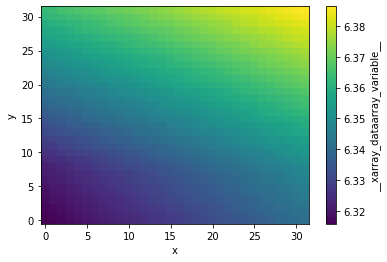

In [5]:
output["__xarray_dataarray_variable__"].plot()

In [3]:
mkdir("./test_dir/gridmet/")

FileNotFoundError: [WinError 3] The system cannot find the path specified: './test_dir/gridmet/'

In [7]:
if not isdir("./test_data"):
    mkdir("./test_data")

if not isdir("./test_data/gridmet"):
    mkdir("./test_data/gridmet")